#Assignment 3: RNNs on game reviews

###Students: Andor Tamás, Seppe Vanrietvelde and Victor Tuytte

In this assignment a recurrent neural network (RNN) will be build using Keras and evaluated on predicting whether game reviews are labeled as funny.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
import json
from keras.layers import LSTM, Dense, Embedding, Input
from keras.models import Sequential
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from nltk import pos_tag
import numpy as np
import re
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

from dl_utils import plot_history

In [ ]:
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

##Loading the data

Run the code block below, while the `game_review.json` file is in the current working directory, to save the review texts and number of funny votes given to those reviews in arrays.

In [ ]:
with open('game_review.json') as file:
    X = []
    y = []
    data = json.load(file)
    for _, review in data["reviews"].items():
        X.append(review["review"])
        y.append(review["votes_funny"])

X = np.array(X)
y = np.array(y)

Some examples:

In [ ]:
print(X[:10])
print(y[:10])

['Game runs amazingly and having a ton of fun :) no valstrax though ;('
 'This game is a disgrace to the Monster Hunter IP. Do better Capcom.'
 "It's the most accessible and detailed monster hunter title to date. The weapons have mostly seen big improvements with the bowguns being a noticeable downgrade from previous titles. There's so much to do with so much detail to breathe life into the environments. My favorite moments have been discovering music in a camp with my friends and taking on a giant ice wyrm on a mountain. Highly recommend."
 'as a gamer i have a right to get destroyed when I want, and right now this game does not offer that'
 "Currently, I have not run into a majority of graphical errors that most people have. What few I did run into, were very breif, but highly distracting. After the few updates done, I've yet to encounter the same errors again.\r\n\r\nThis game is a logical evolution of MH world and MH Rise. The hub integrated into the hunting enviorment creates a li

##Reformat data

###Reviews

First, the text is divided into words. Then, stopwords are removed and all remaining words are lemmatized where possible.

In [ ]:
# Necessary for lemmatization
def get_wordnet_pos(treebank_tag):
    """Convert POS tagging from NLTK to WordNet format."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

In [ ]:
def text_to_words(text):
    """
    Cleans text, tokenizes, and lemmatizes words.
    """
    text = text.lower()
    text = re.sub(r"[^a-z'\s]", " ", text)  # Keep only letters, spaces, and apostrophes
    words = text.split()

    # Remove words containing an apostrophe (') -> Difficult to work with and probably not informative
    words = [word for word in words if "'" not in word]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    words_pos = pos_tag(words)  # Get POS tags
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in words_pos]

    return lemmatized_words

In [ ]:
# Splits each review text in lists of words
X_words = [text_to_words(text) for text in X]

Then the words are tokenized.

In [ ]:
# Makes dictionaries for tokenizing and detokenizing words
unique_words = sorted(set(word for sublist in X_words for word in sublist))

word_to_id = {word: idx + 1 for idx, word in enumerate(unique_words)} # Reserve zero for padding
id_to_word = {idx: word for word, idx in word_to_id.items()}

In [ ]:
# Tokenizes words
X_tokenized = [[word_to_id[word] for word in sublist] for sublist in X_words]

Finally, each review, now a list of tokens representing words, is padded until the length of the longest review.

In [ ]:
# Pads tokenized words to the length of the longest review in words
maxlen = len(max(X_tokenized, key=len))
X_tokenized_padded = sequence.pad_sequences(X_tokenized, maxlen=maxlen, padding="post")

###"Funny" votes

The amount of funny votes reviews get is extremely skewed as seen by the distribution below.

0: 16527
1: 535
2: 84
3: 24
4: 17
5: 3
6: 1
7: 1
8: 1
9: 2
10: 2
11: 1
15: 1
21: 1


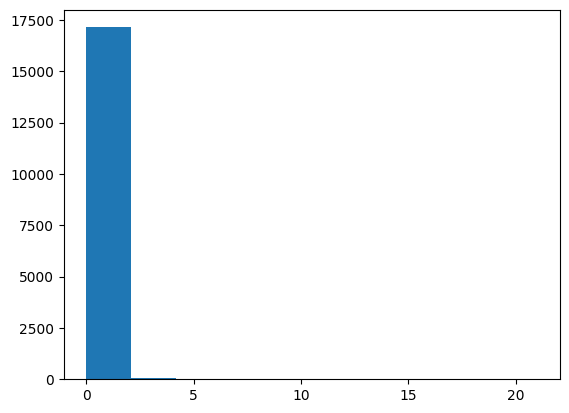

In [ ]:
# Distribution of outcome values
plt.hist(y)

unique, counts = np.unique(y, return_counts=True)
for u, c in zip(unique, counts):
    print(f"{u}: {c}")

Let's convert the regression problem into a binary classification problem. For example whether a review does or does not have votes. The new outcome variable is still extremely imbalanced as almost all reviews got not votes and that group can't be split up further.

0.0: 16527
1.0: 673


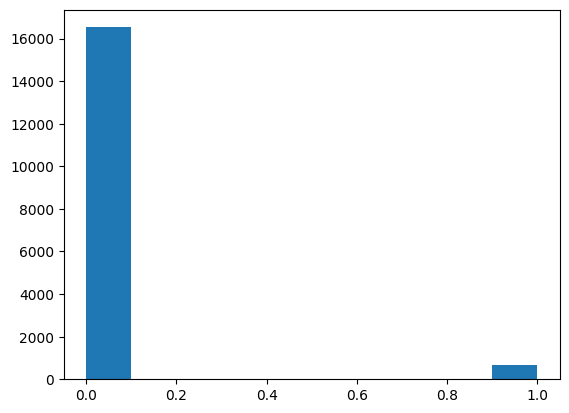

In [ ]:
# Changing the outcome to binary
y_binary = (y > 0).astype("float32")
plt.hist(y_binary)

unique, counts = np.unique(y_binary, return_counts=True)
for u, c in zip(unique, counts):
    print(f"{u}: {c}")

##Splitting the data

A validation and test set are set aside. A fixed seed is used for reproducibility and splitting happens in a stratified manner so that each binary category is represented in the same proportion as the full data. The amount of data put in the validation and test set is intentionally very low to anticipate undersampling in the training data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tokenized_padded, y_binary, test_size=0.05, random_state=42, stratify=y_binary)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.05, random_state=42, stratify=y_train)
# Test size set very low because undersampling the training set will shrink its size

Dataset sizes after the split:

In [ ]:
print(X_train.shape, "training set")
print(X_val.shape, "validation set")
print(X_test.shape, "test set")

(15523, 1045) training set
(817, 1045) validation set
(860, 1045) test set


##Undersampling the majority class

To improve the accuracy on predicting the minority class, random samples from the majority class can be removed until both classes are balanced.

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

The training set will for example have 607 reviews of both classes.

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{np.float32(0.0): np.int64(607), np.float32(1.0): np.int64(607)}


The new dataset sizes are then:

In [ ]:
print(X_train.shape, "training set")
print(X_val.shape, "validation set")
print(X_test.shape, "test set")

(1214, 1045) training set
(817, 1045) validation set
(860, 1045) test set


# Oversampling

Oversampling increases recall by exposing the model to more "funny" examples, but it often lowers precision because the model learns to memorize duplicated data (can overfit) rather than generalize, can also lead to a low F1-score.



In [ ]:
# Check class distribution before oversampling
print("Before Oversampling:", np.bincount(y_train.astype(int)))

In [ ]:
# Apply random oversampling
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

In [ ]:
# Check new class distribution
print("After Oversampling:", np.bincount(y_train.astype(int)))

Epoch 1/3
234/234 ━━━━━━━━━━━━━━━━━━━━ 1069s 5s/step - accuracy: 0.5030 - f1_score: 0.3634 - loss: 0.6937 - val_accuracy: 0.0392 - val_f1_score: 0.0718 - val_loss: 0.7008

Epoch 2/3
234/234 ━━━━━━━━━━━━━━━━━━━━ 1094s 5s/step - accuracy: 0.5045 - f1_score: 0.4908 - loss: 0.6933 - val_accuracy: 0.9608 - val_f1_score: 0.0000e+00 - val_loss: 0.6728

Epoch 3/3
234/234 ━━━━━━━━━━━━━━━━━━━━ 1104s 5s/step - accuracy: 0.4914 - f1_score: 0.3465 - loss: 0.6935 - val_accuracy: 0.9608 - val_f1_score: 0.0000e+00 - val_loss: 0.6819

##Model

Let's start with a simple RNN-architecture consisting of an embedding layer and 32 LSTM units with some degree of dropout. The model is optimized in binary crossentropy through the AdamW algorithm at an initial learning rate of 0.001.

In [ ]:
max_features = len(unique_words) + 1

In [ ]:
def Rnnmodel(embedding_size = 128, dropoutrate = 0.2, recurrent_dropoutrate = 0.2, lr = 0.001):
  model = Sequential()
  model.add(Embedding(max_features, embedding_size))
  model.add(LSTM(32, dropout=dropoutrate, recurrent_dropout=recurrent_dropoutrate))
  model.add(Dense(1, activation="sigmoid"))
  optimizer = keras.optimizers.AdamW(learning_rate=lr)
  model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
  return model

In [ ]:
model1 = Rnnmodel()
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.4730 - loss: 0.6948 - val_accuracy: 0.9608 - val_loss: 0.6877
Epoch 2/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - accuracy: 0.5007 - loss: 0.6933 - val_accuracy: 0.0392 - val_loss: 0.7093
Epoch 3/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.4981 - loss: 0.6941 - val_accuracy: 0.9608 - val_loss: 0.6746


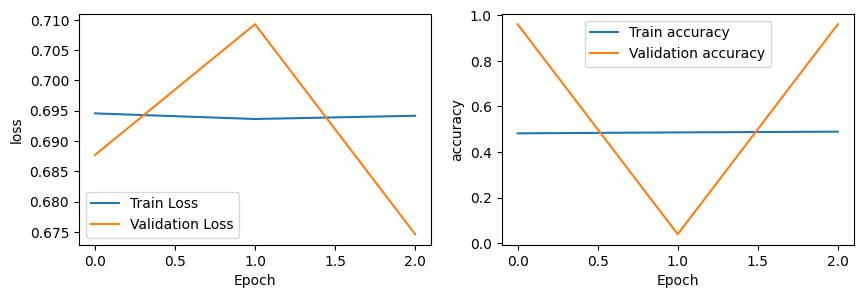

In [ ]:
history = model1.fit(X_train, y_train, batch_size=128, epochs=3, validation_data=(X_val, y_val))
plot_history(history)

In [ ]:
score = model1.evaluate(X_val, y_val, verbose=0)

print("Validation loss:", score[0])
print("Validation accuracy:", score[1])

Validation loss: 0.6746362447738647
Validation accuracy: 0.9608322978019714


26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 582ms/step


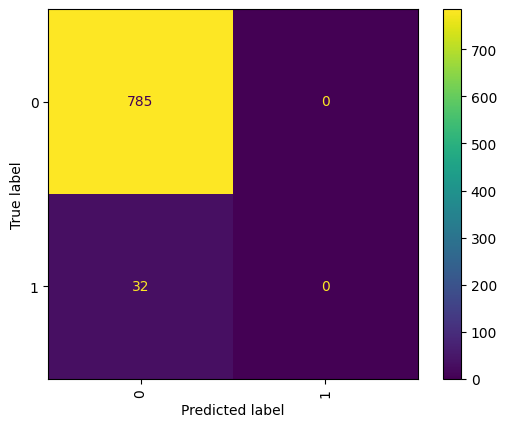

In [ ]:
# Confusion matrix (validation set)
y_pred = model1.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_val, y_pred)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()
_ = plt.xticks(rotation=90)

This simple model basically predicts all reviews as not funny, even after undersampling. The high accuracy doesn't mean anything. Going forward more focus is given on predicting the true class.

##Different loss function
Not necessary anymore, because of undersampling (I will leave it here if we ever need it again)

In [ ]:
# Chat-GPT generated code
def focal_loss(alpha=0.25, gamma=2.0):
    """
    Compute focal loss for binary classification.
    :param alpha: Balancing factor for positive class
    :param gamma: Focusing parameter
    """
    def loss(y_true, y_pred):
        y_pred = keras.backend.clip(y_pred, 1e-7, 1 - 1e-7)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        focal_weight = alpha_factor * keras.backend.pow((1 - p_t), gamma)
        return keras.backend.mean(focal_weight * keras.backend.binary_crossentropy(y_true, y_pred))

    return loss

def precision(y_true, y_pred):
    """Compute precision metric."""
    tp = keras.backend.sum(keras.backend.round(y_true * y_pred))
    fp = keras.backend.sum(keras.backend.round((1 - y_true) * y_pred))
    return tp / (tp + fp + keras.backend.epsilon())

def recall(y_true, y_pred):
    """Compute recall metric."""
    tp = keras.backend.sum(keras.backend.round(y_true * y_pred))
    fn = keras.backend.sum(keras.backend.round(y_true * (1 - y_pred)))
    return tp / (tp + fn + keras.backend.epsilon())

def f1_score(y_true, y_pred):
    """Compute F1-score metric."""
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec + keras.backend.epsilon())

In [ ]:
def Rnnmodel_focal_loss(embedding_size = 128, dropoutrate = 0.2, recurrent_dropoutrate = 0.2, lr = 0.001, alpha = 0.25, gamma = 2):
  model = Sequential()
  model.add(Embedding(max_features, embedding_size))
  model.add(LSTM(32, dropout=dropoutrate, recurrent_dropout=recurrent_dropoutrate))
  model.add(Dense(1, activation="sigmoid"))
  optimizer = keras.optimizers.AdamW(learning_rate=lr)
  model.compile(loss=focal_loss(alpha=alpha, gamma=gamma), optimizer=optimizer, metrics=["accuracy", f1_score])
  return model

In [ ]:
model2 = Rnnmodel_focal_loss()
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 63s 6s/step - accuracy: 0.5253 - f1_score: 0.1247 - loss: 0.0761 - val_accuracy: 0.9608 - val_f1_score: 0.0000e+00 - val_loss: 0.0622
Epoch 2/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - accuracy: 0.4978 - f1_score: 0.0000e+00 - loss: 0.0727 - val_accuracy: 0.9608 - val_f1_score: 0.0000e+00 - val_loss: 0.0641
Epoch 3/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step - accuracy: 0.5080 - f1_score: 0.0000e+00 - loss: 0.0722 - val_accuracy: 0.9608 - val_f1_score: 0.0000e+00 - val_loss: 0.0607


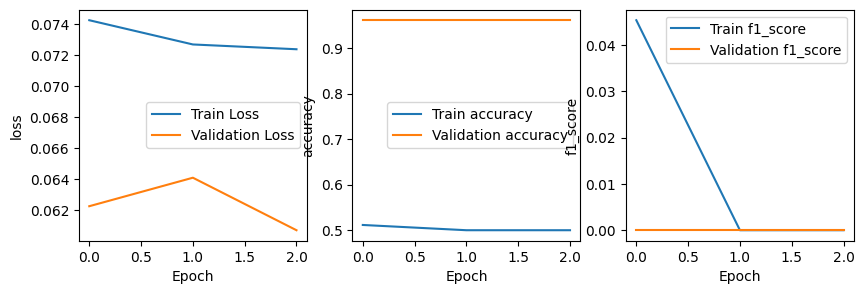

In [ ]:
history = model2.fit(X_train, y_train, batch_size=128, epochs=3, validation_data=(X_val, y_val))
plot_history(history)

In [ ]:
score = model2.evaluate(X_val, y_val, verbose=0)

print("Validation loss:", score[0])
print("Validation accuracy:", score[1])
print("Validation F1-score:", score[2])

Validation loss: 0.06067948043346405
Validation accuracy: 0.9608322978019714
Validation F1-score: 0.0


26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 801ms/step


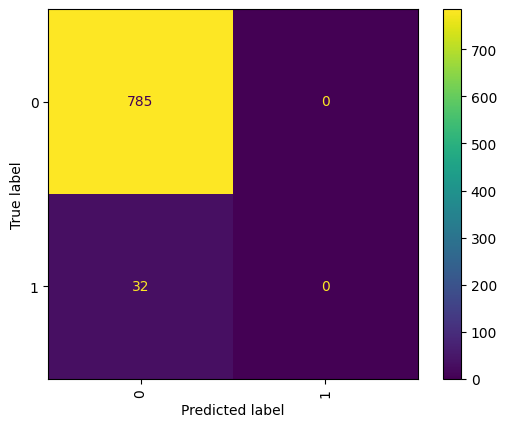

In [ ]:
# Confusion matrix (validation set)
y_pred = model2.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_val, y_pred)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()
_ = plt.xticks(rotation=90)